In [4]:
import pandas as pd

# Load the dataset
df = pd.read_csv("Yelp_Restaurant_Reviews.csv")
df.head()

,Company name,Location,Rating,Review Text
0,sidney dairy barn,sidney,5,All I can say is they have very good ice cream...
1,sidney dairy barn,sidney,4,Nice little local place for ice cream.My favor...
2,sidney dairy barn,sidney,5,A delicious treat on a hot day! Staff was very...
3,sidney dairy barn,sidney,4,This was great service and a fun crew! I got t...
4,sidney dairy barn,sidney,5,This is one of my favorite places to get ice c...


In [5]:
# Extract unique restaurant names and locations
restaurants = df['Company name'].unique()
locations = df['Location'].unique()

location_distribution = df['Location'].value_counts()

for location, count in location_distribution.items():
    restaurants_at_location = df[df['Location'] == location]['Company name'].unique()
    print(f"Restaurants in {location.title()}: {', '.join(restaurants_at_location).title()}")

Restaurants in Las Vegas: Carlos Bakery, Handels Homemade Ice Cream And Yogurt, Bouchon Bakery, Sprinkles Vegas, 85 C Bakery Cafe, Ghirardelli Ice Cream And Chocolate Shop, Milk Bar Vegas, Somisomi, Donut Bar, Sloans Grand Canal Shoppes, La Pasticceria
Restaurants in Charlotte: Amelies French Bakery And Cafe, Jenis Splendid Ice Creams, Villanis Bakery, Ninety S Milkshake Bar, The Batchmaker, Day And Night Exotic Cereal Bar, Matcha Cafe Maiko, The Peach Cobbler Factory
Restaurants in Phoenix: Novel Ice Cream, Melt, Scooptopia, Churn, Mary Coyle
Restaurants in Cleveland: Jack Frost Donuts, Mitchells Homemade Ice Cream Cleveland, Prestis Bakery, Masons Creamery, Honey Hut Ice Cream, Campbells Sweets Factory, Crepes De Luxe
Restaurants in Scottsdale: Sweet Republic, Fatty Daddys
Restaurants in Pittsburgh: The Butterwood Bake Consortium, Pages, Sinful Sweets Chocolate Company, Churn Homemade Ice Cream And Coffee
Restaurants in Champaign: Jarlings Custard Cup, Hopscotch, Paris Super Crepes, 

In [6]:
print(len(restaurants))

49


In [8]:
# Group the restaurant reviews together
restaurant_reviews = df.groupby('Company name')['Review Text'].apply(list).reset_index()

In [9]:
# Preprocess the entries
df['Sentiment'] = df['Rating'].apply(lambda x: 'positive' if x in [4, 5] else 'negative' if x in [1, 2] else 'neutral')
df.head()

,Company name,Location,Rating,Review Text,Sentiment
0,sidney dairy barn,sidney,5,All I can say is they have very good ice cream...,positive
1,sidney dairy barn,sidney,4,Nice little local place for ice cream.My favor...,positive
2,sidney dairy barn,sidney,5,A delicious treat on a hot day! Staff was very...,positive
3,sidney dairy barn,sidney,4,This was great service and a fun crew! I got t...,positive
4,sidney dairy barn,sidney,5,This is one of my favorite places to get ice c...,positive


#### Sentiment

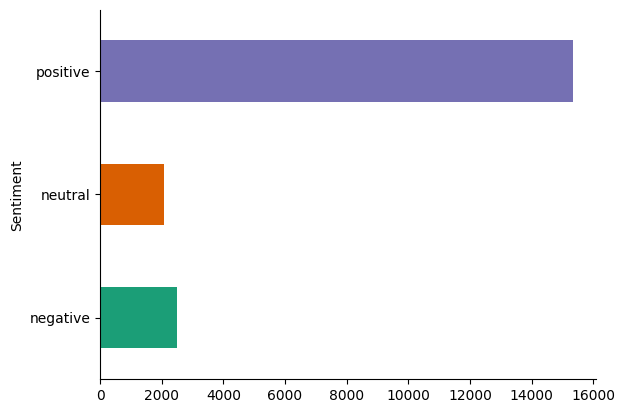

In [10]:
# @title Sentiment

from matplotlib import pyplot as plt
import seaborn as sns
df.groupby('Sentiment').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

#### Rating

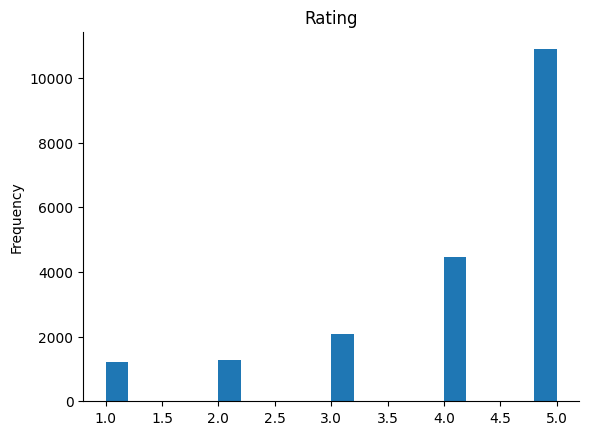

In [11]:
# @title Rating

from matplotlib import pyplot as plt
df['Rating'].plot(kind='hist', bins=20, title='Rating')
plt.gca().spines[['top', 'right',]].set_visible(False)

#### Proportion of Positive Reviews by Company

<Axes: xlabel='Company name'>

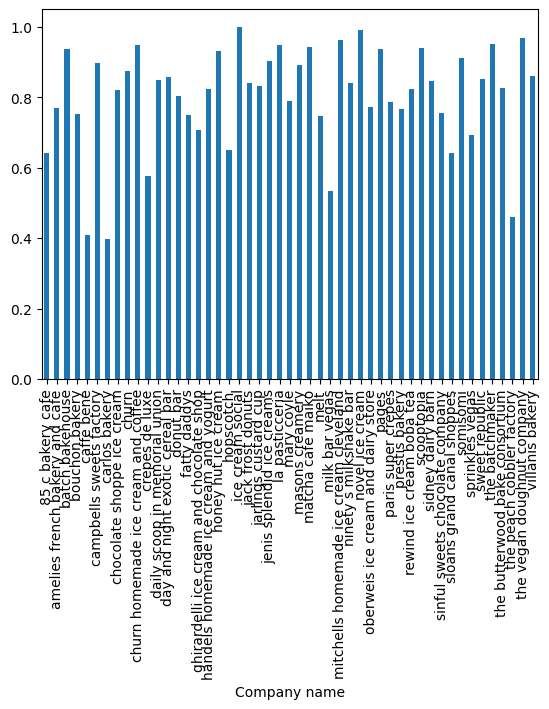

In [12]:
# @title Proportion of Positive Reviews by Company

df.groupby('Company name')['Sentiment'].apply(lambda x: (x == 'positive').mean()).plot(kind='bar')

#### Average rating by location

<Axes: xlabel='Location'>

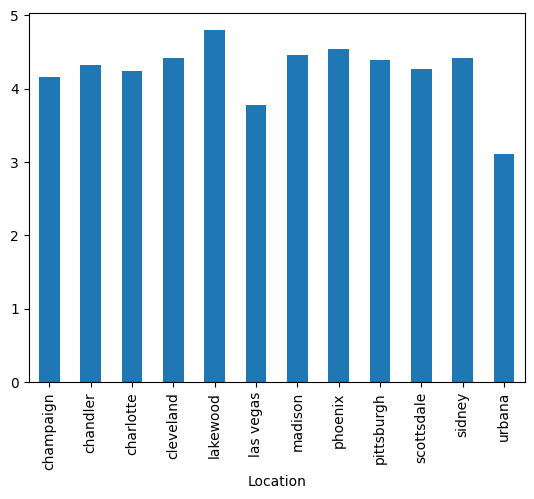

In [13]:
# @title Average rating by location

df.groupby('Location')['Rating'].mean().plot(kind='bar')

#### Sentiment vs Rating

/tmp/ipykernel_145936/2668418250.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(df, x='Rating', y='Sentiment', inner='box', palette='Dark2')


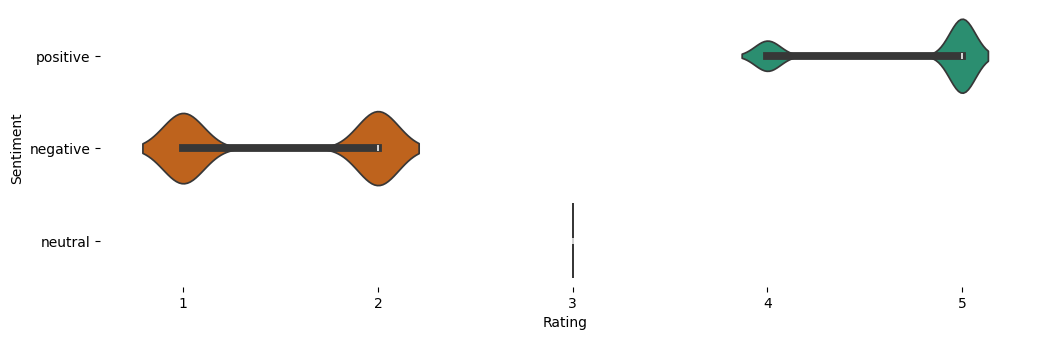

In [14]:
# @title Sentiment vs Rating

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(df['Sentiment'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(df, x='Rating', y='Sentiment', inner='box', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

In [15]:
from transformers import Trainer, TrainingArguments, pipeline, AutoTokenizer, AutoModelForSequenceClassification
from sklearn.model_selection import train_test_split
import pandas as pd
import warnings

warnings.filterwarnings("ignore")

2024-05-03 18:22:54.520832: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-03 18:22:54.556731: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-03 18:22:55.386637: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [16]:
# Split the data into training and test sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=40)

In [18]:
# Load the tokenizer and the model
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased-finetuned-sst-2-english')
# Define model and training arguments
model = AutoModelForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=3) # multiclass classification

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [19]:
# Tokenize the text and add special tokens
def tokenize_text(text):
    return tokenizer(text, padding=True, truncation=True)

train_df['tokenized'] = train_df['Review Text'].apply(tokenize_text)
test_df['tokenized'] = test_df['Review Text'].apply(tokenize_text)
train_df.head()

,Company name,Location,Rating,Review Text,Sentiment,tokenized
6020,bouchon bakery,las vegas,5,I absolutely LOVE their french macarons. I hav...,positive,"[input_ids, attention_mask]"
3518,amelies french bakery and cafe,charlotte,3,As there are not many bakeries in Charlotte (s...,neutral,"[input_ids, attention_mask]"
18933,the batchmaker,charlotte,4,Took a trip from NYC to Charlotte to visit fri...,positive,"[input_ids, attention_mask]"
17227,donut bar,las vegas,5,If you have an addictive personality stay away...,positive,"[input_ids, attention_mask]"
9174,fatty daddys,scottsdale,4,Enjoyed the ice cream; some cool flavors and s...,positive,"[input_ids, attention_mask]"


In [20]:
training_args = TrainingArguments(
    output_dir="./results",          # output directory
    num_train_epochs=3,              # number of training epochs
    per_device_train_batch_size=24,   # batch size per device during training
    per_device_eval_batch_size=32,   # batch size for evaluation
    warmup_steps=500,                # Number of warm steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir="./logs",            # directory for storing logs
    logging_steps=10           
)

In [22]:
from torch.utils.data import Dataset

class ReviewsDataset(Dataset):
    def __init__(self, dataframe):
        self.data = dataframe

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data.iloc[idx]
        # Assuming the 'tokenized' column contains a dictionary with 'input_ids' and 'attention_mask'
        input_ids = item['tokenized']['input_ids']
        attention_mask = item['tokenized']['attention_mask']
        
        if item['Sentiment'] == 'positive':
            labels = 2
        elif item['Sentiment'] == 'neutral':
            labels = 1
        else:
            labels = 0
            
        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'labels': labels
        }

train_dataset = ReviewsDataset(train_df)
test_dataset = ReviewsDataset(test_df)

In [23]:
# Create and use the Trainer
from transformers import DataCollatorWithPadding

# Instantiate a data collator that will dynamically pad the batches during training
data_collator = DataCollatorWithPadding(tokenizer, return_tensors="pt")

In [24]:
import numpy as np
from datasets import load_metric

def compute_metrics(eval_pred):
    load_accuracy = load_metric("accuracy")
    load_f1 = load_metric("f1")

    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    accuracy = load_accuracy.compute(predictions=predictions, references=labels)["accuracy"]
    f1 = load_f1.compute(predictions=predictions, references=labels, average='weighted')["f1"]
    return {"accuracy": accuracy, "f1": f1}

## Do not run the following cell as it will start training the transformer model which consumes a lot of time. Instead run the subsequent cell to load the trained model from the pickle file

In [47]:
import pickle

# Create a Trainer instance with the data collator
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

# Train the model
trainer.train()

with open('trained_transformer_model_CPU.pkl', 'wb') as f:
    pickle.dump(trainer.model, f)

# Evaluate the model
eval_results = trainer.evaluate()
print(eval_results)

Step,Training Loss
10,1.125400
20,1.102900
30,1.056100
40,0.975600
50,0.861200
60,0.789000
70,0.649100
80,0.722800
90,0.645900
100,0.640700


{'eval_loss': 0.3655862808227539, 'eval_accuracy': 0.8881909547738693, 'eval_f1': 0.888641596504324, 'eval_runtime': 485.0552, 'eval_samples_per_second': 8.205, 'eval_steps_per_second': 0.258, 'epoch': 3.0}


### Run the following cell to get the trained transformer model.
To get the pickle file, follow this link: https://drive.google.com/file/d/1Y4mxZ7-hzlQi9OL1U0IbVYcaYBIJL85N/view?usp=sharing

Make sure that the pickle file is downloaded in the same directory as this notebook

In [26]:
# Load the pretrained model from the pickle file so that retraining it from scratch is not necessary
model = pickle.load(open('trained_transformer_model_CPU.pkl', 'rb'))

In [38]:
# Load the training arguments, test dataset, and the data collator and metrics computation function if needed
training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=3,              # number of training epochs
    per_device_eval_batch_size=64,   # batch size for evaluation
)

# Create a Trainer instance
trainer = Trainer(
    model=model,
    args=training_args,
    eval_dataset=test_dataset,    # test_dataset is loaded or defined
    data_collator=data_collator,  # data_collator that was used initially
    compute_metrics=compute_metrics  # compute_metrics that was used initially
)

eval_results = trainer.evaluate()
print(eval_results)


{'eval_loss': 0.3655862808227539, 'eval_accuracy': 0.8881909547738693, 'eval_f1': 0.888641596504324, 'eval_runtime': 629.8956, 'eval_samples_per_second': 6.319, 'eval_steps_per_second': 0.1}


### Compile the dictionaries

In [27]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

nltk.download('vader_lexicon')
# Function to map polarity score to a rating
def map_score_to_rating(score):
    if score <= -0.2:
        return 1
    elif score <= 0.4:
        return 2
    elif score <= 0.8:
        return 3
    elif score <= 0.9:
        return 4
    else:
        return 5

# Instantiate the SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()

# Calculate the polarity score of every review in the dataset
df['Polarity_Score'] = df['Review Text'].apply(lambda x: sid.polarity_scores(x)['compound'])

# Map the polarity score to a rating on a scale of 1-5
df['Calculated_Rating'] = df['Polarity_Score'].apply(map_score_to_rating)

df.head()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/lohith/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


,Company name,Location,Rating,Review Text,Sentiment,Polarity_Score,Calculated_Rating
0,sidney dairy barn,sidney,5,All I can say is they have very good ice cream...,positive,0.8803,4
1,sidney dairy barn,sidney,4,Nice little local place for ice cream.My favor...,positive,0.9509,5
2,sidney dairy barn,sidney,5,A delicious treat on a hot day! Staff was very...,positive,0.8803,4
3,sidney dairy barn,sidney,4,This was great service and a fun crew! I got t...,positive,0.9400,5
4,sidney dairy barn,sidney,5,This is one of my favorite places to get ice c...,positive,0.9924,5


In [28]:
import pprint

# Create a dictionary where the key is the restaurant name and the value is the location
restaurant_location_dict = {name: location for name, location in zip(df['Company name'], df['Location'])}
restaurant_location_dict

{'sidney dairy barn': 'sidney',
 'rewind ice cream boba tea': 'chandler',
 'carlos bakery': 'las vegas',
 'the vegan doughnut company': 'lakewood',
 'the butterwood bake consortium': 'pittsburgh',
 'handels homemade ice cream and yogurt': 'las vegas',
 'amelies french bakery and cafe': 'charlotte',
 'bouchon bakery': 'las vegas',
 'novel ice cream': 'phoenix',
 'sweet republic': 'scottsdale',
 'sprinkles vegas': 'las vegas',
 'fatty daddys': 'scottsdale',
 '85 c bakery cafe': 'las vegas',
 'melt': 'phoenix',
 'jack frost donuts': 'cleveland',
 'jenis splendid ice creams': 'charlotte',
 'mitchells homemade ice cream cleveland': 'cleveland',
 'prestis bakery': 'cleveland',
 'villanis bakery': 'charlotte',
 'batch bakehouse': 'madison',
 'chocolate shoppe ice cream': 'madison',
 'ghirardelli ice cream and chocolate shop': 'las vegas',
 'milk bar vegas': 'las vegas',
 'jarlings custard cup': 'champaign',
 'somisomi': 'las vegas',
 'scooptopia': 'phoenix',
 'churn': 'phoenix',
 'donut bar':

In [40]:
# Group by 'Company name' and get the top 5 reviews for each group
top_reviews = df.groupby('Company name').apply(lambda x: x.nlargest(5, 'Polarity_Score')).reset_index(drop=True)
top_reviews_for_restaurant = top_reviews.groupby('Company name')['Review Text'].apply(list).reset_index()
reviews_dict = top_reviews_for_restaurant.set_index('Company name')['Review Text'].to_dict()
# pprint.pprint(reviews_dict)

In [41]:
# Aggregate the Calculated_Ratings for every restaurant to get the mean Calculated_Rating
mean_scores = df.groupby('Company name')['Calculated_Rating'].mean().reset_index()
scores_dict = mean_scores.set_index('Company name')['Calculated_Rating'].to_dict()
pprint.pprint(scores_dict)

{'85 c bakery cafe': 3.737704918032787,
 'amelies french bakery and cafe': 4.066111655239961,
 'batch bakehouse': 4.273170731707317,
 'bouchon bakery': 3.9314574314574315,
 'caffe bene': 3.732394366197183,
 'campbells sweets factory': 4.430379746835443,
 'carlos bakery': 3.3868217054263567,
 'chocolate shoppe ice cream': 3.8980891719745223,
 'churn': 4.337110481586402,
 'churn homemade ice cream and coffee': 4.473684210526316,
 'crepes de luxe': 3.5176470588235293,
 'daily scoop in memorial union': 4.029850746268656,
 'day and night exotic cereal bar': 4.23943661971831,
 'donut bar': 4.22265625,
 'fatty daddys': 4.112054329371817,
 'ghirardelli ice cream and chocolate shop': 3.8466666666666667,
 'handels homemade ice cream and yogurt': 3.9736456808199123,
 'honey hut ice cream': 4.152671755725191,
 'hopscotch': 4.257731958762887,
 'ice cream social': 4.884615384615385,
 'jack frost donuts': 4.033980582524272,
 'jarlings custard cup': 3.8833333333333333,
 'jenis splendid ice creams': 4.

### Evaluating the Recommendation System with the trained transformers model

In [42]:
top_reviews.head(5)

,Company name,Location,Rating,Review Text,Sentiment,Polarity_Score,Calculated_Rating
0,85 c bakery cafe,las vegas,5,85 degrees is always a good spot to curb any o...,positive,0.9992,5
1,85 c bakery cafe,las vegas,5,Life looks wonderful and beautiful through ano...,positive,0.9986,5
2,85 c bakery cafe,las vegas,4,Stopped by on 1/21 as it was near a place I wa...,positive,0.9976,5
3,85 c bakery cafe,las vegas,4,So this is one I've been waiting for and I am ...,positive,0.9965,5
4,85 c bakery cafe,las vegas,4,I've been wanting to check out this place for ...,positive,0.9964,5


In [43]:
def new_senti(x):
    if x == 5 or x == 4:
        return 'positive'
    elif x == 1 or x == 2:
        return 'negative'
    else:
        return 'neutral'
        
    
top_reviews['Calculated_Senti_Score'] = top_reviews['Calculated_Rating'].apply(new_senti)

In [44]:
top_reviews.head(5)

,Company name,Location,Rating,Review Text,Sentiment,Polarity_Score,Calculated_Rating,Calculated_Senti_Score
0,85 c bakery cafe,las vegas,5,85 degrees is always a good spot to curb any o...,positive,0.9992,5,positive
1,85 c bakery cafe,las vegas,5,Life looks wonderful and beautiful through ano...,positive,0.9986,5,positive
2,85 c bakery cafe,las vegas,4,Stopped by on 1/21 as it was near a place I wa...,positive,0.9976,5,positive
3,85 c bakery cafe,las vegas,4,So this is one I've been waiting for and I am ...,positive,0.9965,5,positive
4,85 c bakery cafe,las vegas,4,I've been wanting to check out this place for ...,positive,0.9964,5,positive


In [45]:
top_reviews['Calculated_Senti_Score'].unique()

array(['positive'], dtype=object)

In [46]:
top_reviews.drop(['Polarity_Score', 'Calculated_Rating','Sentiment'], axis=1, inplace=True)

In [47]:
top_reviews.rename(columns={'Calculated_Senti_Score': 'Sentiment'}, inplace=True)

In [48]:
top_reviews['tokenized'] = top_reviews['Review Text'].apply(tokenize_text)
# top_reviews.drop(['Polarity_Score', 'Calculated_Rating'], axis=1, inplace=True)
reviews_dataset = ReviewsDataset(top_reviews)
y_pred = trainer.predict(reviews_dataset)
type(y_pred)

transformers.trainer_utils.PredictionOutput

In [49]:
y_pred_final = y_pred[1]

In [50]:
reviews_dataset.data

,Company name,Location,Rating,Review Text,Sentiment,tokenized
0,85 c bakery cafe,las vegas,5,85 degrees is always a good spot to curb any o...,positive,"[input_ids, attention_mask]"
1,85 c bakery cafe,las vegas,5,Life looks wonderful and beautiful through ano...,positive,"[input_ids, attention_mask]"
2,85 c bakery cafe,las vegas,4,Stopped by on 1/21 as it was near a place I wa...,positive,"[input_ids, attention_mask]"
3,85 c bakery cafe,las vegas,4,So this is one I've been waiting for and I am ...,positive,"[input_ids, attention_mask]"
4,85 c bakery cafe,las vegas,4,I've been wanting to check out this place for ...,positive,"[input_ids, attention_mask]"
...,...,...,...,...,...,...
240,villanis bakery,charlotte,5,"Behold the almighty. If you know, you know. I'...",positive,"[input_ids, attention_mask]"
241,villanis bakery,charlotte,4,I have been waiting to try this place since mo...,positive,"[input_ids, attention_mask]"
242,villanis bakery,charlotte,5,You've probably heard of places to die for so ...,positive,"[input_ids, attention_mask]"
243,villanis bakery,charlotte,5,"YUM , Let me start off by reminding reviewers ...",positive,"[input_ids, attention_mask]"


In [51]:
# This function is meant for mapping sentiments to labels
def complex_function(x):
    if x == 'positive':
        return 2
    elif x == 'neutral':
        return 1
    else:
        return 0

In [52]:
label = reviews_dataset.data['Sentiment'].apply(complex_function)

In [53]:
# Converting the labels to a list instead of a Dataframe
y_test = list(label)

In [54]:
# Calculating the accuracy of the predicted values from the transformer model to the actual values of the recommendation system
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred_final)

1.0

In [55]:
# Calculating the precision, recall and f1 score of the predicted values from the transformer model to the actual values of the recommendation system
from sklearn.metrics import precision_recall_fscore_support
precision_recall_fscore_support(y_test, y_pred_final, average='weighted')

(1.0, 1.0, 1.0, None)

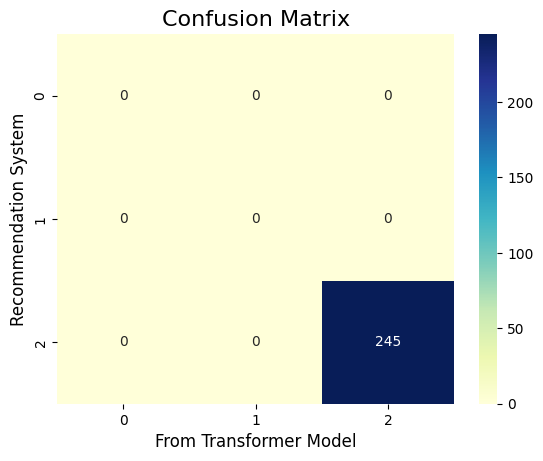

In [56]:
from sklearn.metrics import confusion_matrix
# Create a confusion matrix
cm = confusion_matrix(y_test, y_pred_final,labels = [0,1,2])

# Plot the confusion matrix
sns.heatmap(cm, annot=True,fmt='d', cmap='YlGnBu')
plt.xlabel('From Transformer Model',fontsize=12)
plt.ylabel('Recommendation System',fontsize=12)
plt.title('Confusion Matrix',fontsize=16)
plt.show()

In the above confusion matrix, we can see that our recommendation system (which uses the SentimentIntensityAnalyzer) shows all the recommended reviews as positive and after evaluating the top reviews by the trained transformer model, all of the recommended reviews were actually classified as 'positive' by our trained transformer model. This matrix was created to analyze the actual recommendation system with the sentiments analyzed by our trained transformer model.

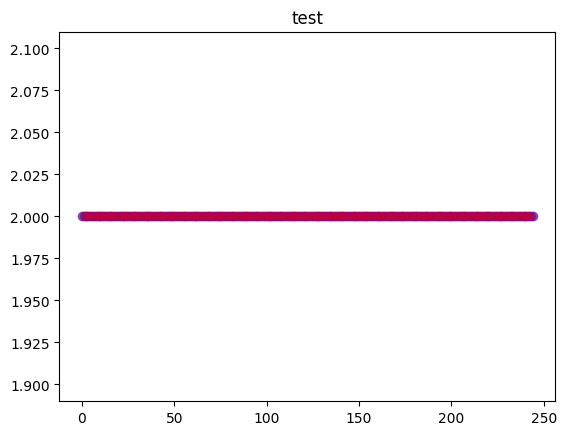

In [57]:
import matplotlib.pyplot as plt
import numpy as np


def plotGraph(y_test,y_pred,regressorName):
    if max(y_test) >= max(y_pred):
        my_range = int(max(y_test))
    else:
        my_range = int(max(y_pred))
    plt.scatter(range(len(y_test)), y_test, color='blue',alpha=0.5)
    plt.scatter(range(len(y_pred)), y_pred, color='red',alpha = 0.2)
    plt.title(regressorName)
    plt.show()
    return




plotGraph(y_test, y_pred_final, "test")

The above graph is the representation of the sentiments from the Transformer model and the Recommendation system.
#### Observations
    - The Transformer model and the Recommendation system are both mapping the points at the exact same locations for all restaurants 

### Perform Named Entity Recognition to identify foods to try at each restaurant

In [226]:
from transformers import pipeline, AutoTokenizer, AutoModelForTokenClassification
import pandas as pd 
from collections import defaultdict
import pprint

# Maximum length of input for the model
max_input_length = 512

tokenizer = AutoTokenizer.from_pretrained("Dizex/InstaFoodRoBERTa-NER")
model = AutoModelForTokenClassification.from_pretrained("Dizex/InstaFoodRoBERTa-NER")

# Load the NER pipeline
ner = pipeline("ner", model=model, tokenizer=tokenizer)

# Load the sentiment analysis pipeline
sentiment_analysis = pipeline("sentiment-analysis", model='distilbert-base-uncased-finetuned-sst-2-english')

def convert_entities_to_list(text, entities: [dict]) -> [str]:
        ents = []
        for ent in entities:
            e = {"start": ent["start"], "end": ent["end"], "label": ent["entity_group"]}
            if ents and -1 <= ent["start"] - ents[-1]["end"] <= 1 and ents[-1]["label"] == e["label"]:
                ents[-1]["end"] = e["end"]
                continue
            ents.append(e)

        return [text[e["start"]:e["end"]] for e in ents]

restaurant_foods_to_try = defaultdict(list)

for index, row in restaurant_reviews.iterrows():
    # Get the restaurant name and the list of reviews for the restaurant
    restaurant_name = row['Company name']
    reviews = row['Review Text']
         
    # Perform sentiment analysis on each review
    sentiments = []
    for review in reviews:
         # Split the review into chunks of max_input_length
         review_chunks = [review[i: i + max_input_length] for i in range(0, len(review), max_input_length)]

         # Perform sentiment analysis on each chunk 
         chunk_sentiments = [result['label'] for result in sentiment_analysis(review_chunks)]

         sentiments.extend(chunk_sentiments)

    # Filter out positive reviews
    positive_reviews = [reviews[i] for i in range(len(reviews)) if sentiments[i] == 'POSITIVE']
    
    # Extract foods to try from positive reviews
    foods_to_try = []
    foods_to_try_count = defaultdict(int)
    for review in positive_reviews:
        entities = ner(review, aggregation_strategy='simple')
        food_entities = convert_entities_to_list(review, entities)
        for food in food_entities:
            foods_to_try_count[food] += 1
            if len(food.split()) > 1:
                foods_to_try.append(food)
        
        if len(foods_to_try) > 20:
             break

    # Remove duplicates
    foods_to_try = list(set(foods_to_try))

    # Store the foods to try for the restaurant
    restaurant_foods_to_try[restaurant_name] = foods_to_try

print(dict(restaurant_foods_to_try))

{'85 c bakery cafe': ['iced coffee', 'spicy sausage', 'thai tea', 'chocolate bun', 'Sea salt coffee', 'milk tea', 'elote bread', 'chocolate mousse', 'matcha cake roll', 'chocolate roll', 'tiramisu cake', 'red velvet', 'sea salt jasmine iced tea', 'rose milk tea', 'tiger boba latte', 'chocolate paste', 'cheese dog', 'strawberry cream bun', 'egg tarts', 'milk pudding tart', 'milk coffee', 'elote bun'], 'amelies french bakery and cafe': ['iced coffee', 'Peaches and Creme soda', 'strawberry fruit tart', 'apple tart', 'lavender lemonade', 'peaches and Creme soda', 'peach purÃ©e', 'key lime pie/tart', 'dark chocolate', 'caramel cafÃ© mocha', 'caramel brownie', 'peach tart', 'strawberry shortcake', 'peaches and creme tart', 'caramel brownies', 'Italian Creme Soda', 'ham and cheese croissant', 'lavender lemon', 'strawberry pistachio croissant', 'vanilla coffee', 'raspberry merengue'], 'batch bakehouse': ['monkey bread', 'cinnamon rolls', 'lemon berry', 'raspberry bars', 'chorizo bread', 'ham a

### Compile all the dictionaries to get a list of dictionary objects for each restaurant

In [58]:
restaurants = []
import pickle
import json

with open('food_recommendations.pkl', 'rb') as f:
    food_recommendations = pickle.load(f)

for name, rating in scores_dict.items():
    location = restaurant_location_dict[name]
    reviews = reviews_dict[name]
    foods = food_recommendations[name]
    restaurants.append({
        'name': name,
        'location': location,
        'rating': rating,
        'reviews': reviews,
        'foods': foods
    })

with open('restaurants.json', 'w') as json_file:
    json.dump(restaurants, json_file, indent=4)

The above json file ("restaurants.json") will be used by the UI to render the top rated restaurants along with their rating, top rated reviews and must-try foods